<a href="https://colab.research.google.com/github/Can-Bot/DL4-AE/blob/main/2542341T_DL_CW_2024_damages.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Damages - Deep Learning Coursework 2024 - 2542341T


## Housekeeping

In [168]:
!pip install gdown pytorch_lightning
!pip3 install ax-platform
!pip3 install lightning
!pip3 install wandb

In [169]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import pytorch_lightning as pl
from lightning.pytorch.loggers import CSVLogger
from pytorch_lightning.trainer import Trainer
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
import pytorch_lightning as pl

import os
import pandas as pd
import PIL
PIL.Image.MAX_IMAGE_PIXELS = 243748701
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import gdown
import shutil

DEVICE = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

# Load dataset

We then load the metadata in a dataframe for convenience

In [170]:
!pwd

/content


In [171]:
!gdown 1v8aUId0-tTW3ln3O2BE4XajQeCToOEiS -O damages.zip

Failed to retrieve file url:

	Too many users have viewed or downloaded this file recently. Please
	try accessing the file again later. If the file you are trying to
	access is particularly large or is shared with many people, it may
	take up to 24 hours to be able to view or download the file. If you
	still can't access a file after 24 hours, contact your domain
	administrator.

You may still be able to access the file from the browser:

	https://drive.google.com/uc?id=1v8aUId0-tTW3ln3O2BE4XajQeCToOEiS

but Gdown can't. Please check connections and permissions.


In [172]:
!ln -s /content/drive/MyDrive/damage_data

ln: failed to create symbolic link './damage_data': File exists


In [173]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [174]:
# set  that to wherever you want to store the data (eg, your Google Drive), choose a persistent location!
root_dir = '/content/'
data_dir = os.path.join(root_dir, "damage_data")
csv_path = os.path.join(data_dir, 'metadata.csv')
drive_backup_dir = "/content/drive/MyDrive/damage_data"

try:
    df = pd.read_csv(csv_path)

except:  # if the dataset has not been downloaded yet, do it.
    print("error:", e)
    zip_path = os.path.join(root_dir, 'damages.zip')
    gdown.download(id='1v8aUId0-tTW3ln3O2BE4XajQeCToOEiS', output=zip_path)
    shutil.unpack_archive(zip_path, root_dir)
    df = pd.read_csv(csv_path)

This dataframe has the paths of where the dataset images and annotation labels are stored, plus classification labels.

In [175]:
df

id   material             content  \
0    cljmrkz5n341f07clcujw105j  Parchment  Artistic depiction   
1    cljmrkz5n341n07clf1u410ed  Parchment  Artistic depiction   
2    cljmrkz5n341r07clhl93dpre  Parchment  Artistic depiction   
3    cljmrkz5n341v07cl2gfhd6zj  Parchment  Artistic depiction   
4    cljmrkz5n341z07cldbn01un3  Parchment  Artistic depiction   
..                         ...        ...                 ...   
390  clnofow7i00n2076ubpfodf4d       Wood  Artistic depiction   
391  clnrm7fvu092q07840tq9zs03       Wood  Artistic depiction   
392  clnrm7fvu092r0784a6p2m5li       Wood  Artistic depiction   
393  clnrm7fvu092s0784tgwccewe       Wood  Artistic depiction   
394  clnrm7fvu092t0784ltljhiu0       Wood  Artistic depiction   

                                            image_path  \
0    ./damage_data/image_path/cljmrkz5n341f07clcujw...   
1    ./damage_data/image_path/cljmrkz5n341n07clf1u4...   
2    ./damage_data/image_path/cljmrkz5n341r07clhl93...   
3    ./damage_data/image_path/cljmrkz5n341v07cl2gfh...   
4    ./damage_data/image_path/cljmrkz5n341z07cldbn0...   
..                                                 ...   
390  ./damage_data/image_path/clnofow7i00n2076ubpfo...   
391  ./damage_data/image_path/clnrm7fvu092q07840tq9...   
392  ./damage_data/image_path/clnrm7fvu092r0784a6p2...   
393  ./damage_data/image_path/clnrm7fvu092s0784tgwc...   
394  ./damage_data/image_path/clnrm7fvu092t0784ltlj...   

                                       annotation_path  \
0    ./damage_data/annotation_path/cljmrkz5n341f07c...   
1    ./damage_data/annotation_path/cljmrkz5n341n07c...   
2    ./damage_data/annotation_path/cljmrkz5n341r07c...   
3    ./damage_data/annotation_path/cljmrkz5n341v07c...   
4    ./damage_data/annotation_path/cljmrkz5n341z07c...   
..                                                 ...   
390  ./damage_data/annotation_path/clnofow7i00n2076...   
391  ./damage_data/annotation_path/clnrm7fvu092q078...   
392  ./damage_data/annotation_path/clnrm7fvu092r078...   
393  ./damage_data/annotation_path/clnrm7fvu092s078...   
394  ./damage_data/annotation_path/clnrm7fvu092t078...   

                                   annotation_rgb_path  
0    ./damage_data/annotation_rgb_path/cljmrkz5n341...  
1    ./damage_data/annotation_rgb_path/cljmrkz5n341...  
2    ./damage_data/annotation_rgb_path/cljmrkz5n341...  
3    ./damage_data/annotation_rgb_path/cljmrkz5n341...  
4    ./damage_data/annotation_rgb_path/cljmrkz5n341...  
..                                                 ...  
390  ./damage_data/annotation_rgb_path/clnofow7i00n...  
391  ./damage_data/annotation_rgb_path/clnrm7fvu092...  
392  ./damage_data/annotation_rgb_path/clnrm7fvu092...  
393  ./damage_data/annotation_rgb_path/clnrm7fvu092...  
394  ./damage_data/annotation_rgb_path/clnrm7fvu092...  

[395 rows x 6 columns]

The images in the dataset are categorised in terms of the type of `material`, meaning what was the original picture on, eg, Parchment, Glass or Textile.

In [176]:
df['material'].unique()

array(['Parchment', 'Film emulsion', 'Glass', 'Paper', 'Tesserae',
       'Canvas', 'Textile', 'Ceramic', 'Wood'], dtype=object)

Moreover, images are also categorised in terms on the `content` of the image, meaning what is depicted: eg, Line art, geometric patterns, etc.

In [177]:
df['content'].unique()

array(['Artistic depiction', 'Line art', 'Photographic depiction',
       'Geometric patterns'], dtype=object)

## Labels
Segmentation labels are saved as a PNG image, where each number from 1 to 15 corresponds to a damage class like Peel, Scratch etc; the Background class is set to 255, and the Clean class (no damage) is set to 0. We also provide code to convert these annotation values to RGB colours for nicer visualisation, but for training you should use the original annotations.

In [178]:
name_color_mapping = {
    "Material loss": "#1CE6FF",
    "Peel": "#FF34FF",
    "Dust": "#FF4A46",
    "Scratch": "#008941",
    "Hair": "#006FA6",
    "Dirt": "#A30059",
    "Fold": "#FFA500",
    "Writing": "#7A4900",
    "Cracks": "#0000A6",
    "Staining": "#63FFAC",
    "Stamp": "#004D43",
    "Sticker": "#8FB0FF",
    "Puncture": "#997D87",
    "Background": "#5A0007",
    "Burn marks": "#809693",
    "Lightleak": "#f6ff1b",
}

class_names = [ 'Material loss', 'Peel', 'Dust', 'Scratch',
                'Hair', 'Dirt', 'Fold', 'Writing', 'Cracks', 'Staining', 'Stamp',
                'Sticker', 'Puncture', 'Burn marks', 'Lightleak', 'Background']

class_to_id = {class_name: idx+1 for idx, class_name in enumerate(class_names)}
class_to_id['Background'] = 255  # Set the Background ID to 255

def hex_to_rgb(hex_color: str) -> tuple:
    hex_color = hex_color.lstrip('#')
    return tuple(int(hex_color[i:i+2], 16) for i in (0, 2, 4))

id_to_rgb = {class_to_id[class_name]: hex_to_rgb(color) for class_name, color in name_color_mapping.items()}
id_to_rgb[0] = (0,0,0)

# Create id2label mapping: ID to class name
id2label = {idx: class_name for class_name, idx in class_to_id.items()}

# Create label2id mapping: class name to ID, which is the same as class_to_id
label2id = class_to_id

# Non-damaged pixels
id2label[0] = 'Clean'
label2id['Clean'] = 0

In [179]:
print(id2label)

{1: 'Material loss', 2: 'Peel', 3: 'Dust', 4: 'Scratch', 5: 'Hair', 6: 'Dirt', 7: 'Fold', 8: 'Writing', 9: 'Cracks', 10: 'Staining', 11: 'Stamp', 12: 'Sticker', 13: 'Puncture', 14: 'Burn marks', 15: 'Lightleak', 255: 'Background', 0: 'Clean'}


In [180]:
from IPython.display import Markdown

legend='#### Colour labels for each damage type\n'
for damage in class_names:
    legend += '- <span style="color: {color}">{damage}</span>.\n'.format(color=name_color_mapping[damage], damage=damage)
display(Markdown(legend))

#### Colour labels for each damage type
- <span style="color: #1CE6FF">Material loss</span>.
- <span style="color: #FF34FF">Peel</span>.
- <span style="color: #FF4A46">Dust</span>.
- <span style="color: #008941">Scratch</span>.
- <span style="color: #006FA6">Hair</span>.
- <span style="color: #A30059">Dirt</span>.
- <span style="color: #FFA500">Fold</span>.
- <span style="color: #7A4900">Writing</span>.
- <span style="color: #0000A6">Cracks</span>.
- <span style="color: #63FFAC">Staining</span>.
- <span style="color: #004D43">Stamp</span>.
- <span style="color: #8FB0FF">Sticker</span>.
- <span style="color: #997D87">Puncture</span>.
- <span style="color: #809693">Burn marks</span>.
- <span style="color: #f6ff1b">Lightleak</span>.
- <span style="color: #5A0007">Background</span>.


## Create dataset splits

Here is an example of how to split the dataset for Leave-one-out cross validation (LOOCV) based on material.

In [181]:
def create_leave_one_out_splits(df, criterion='material'):

    grouped = df.groupby(criterion)
    content_splits = {name: group for name, group in grouped}
    unique_val = df[criterion].unique()

    # Initialize a dictionary to hold the train and validation sets for each LOOCV iteration
    loocv_splits = {}

    for value in unique_val:
        # Create the validation set
        val_set = content_splits[value]

        # Create the training set
        train_set = pd.concat([content_splits[c] for c in unique_val if c != value])

        # Add these to the loocv_splits dictionary
        loocv_splits[value] = {'train_set': train_set, 'val_set': val_set}

    return loocv_splits


For this coursework, we will want to assess the generalisation of the method, so for that we will keep one type of material (`Canvas`) as test set, and only train on the remaining ones.

In [182]:
# split the dataset according to material type
full_splits = create_leave_one_out_splits(df, 'material')

# use Canvas as test set
test_set = full_splits['Canvas']['val_set']

# use the rest as training set
train_set = full_splits['Canvas']['train_set']

# prepare a leave-one-out cross validation for the training set
loocv_splits = create_leave_one_out_splits(train_set, 'material')

# identify the different type of image content
unique_material = train_set['material'].unique()
print(unique_material)


['Parchment' 'Film emulsion' 'Glass' 'Paper' 'Tesserae' 'Textile'
 'Ceramic' 'Wood']


To help you, here are some helper functions to help crop and process images.

In [183]:
def random_square_crop_params(image, target_size):
    width, height = image.size
    min_edge = min(width, height)

    # Conditionally set the range for random crop size
    lower_bound = min(min_edge, target_size)
    upper_bound = max(min_edge, target_size)

    # Generate crop_size
    crop_size = random.randint(lower_bound, upper_bound)

    # Check and adjust if crop_size is larger than any dimension of the image
    if crop_size > width or crop_size > height:
        crop_size = min(width, height)

    # Generate random coordinates for the top-left corner of the crop
    x = random.randint(0, width - crop_size)
    y = random.randint(0, height - crop_size)

    return (x, y, x + crop_size, y + crop_size)

def apply_crop_and_resize(image, coords, target_size):
    image_crop = image.crop(coords)
    image_crop = image_crop.resize((target_size, target_size), Image.NEAREST)
    return image_crop

We also provide a simple class for holding the dataset

In [184]:
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import random
import numpy as np
from PIL import Image

from torchvision import transforms

class CustomDataset(Dataset):
    def __init__(self, dataframe, target_size, is_train=True):
        self.dataframe = dataframe
        self.target_size = target_size
        self.is_train = is_train

        self.to_tensor = transforms.ToTensor()

        # Define the normalization transform
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                              std=[0.229, 0.224, 0.225])

    def __len__(self):
            return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        image = Image.open(row['image_path']).convert('RGB')
        annotation = Image.open(row['annotation_path']).convert('L')
        annotation_rgb = Image.open(row['annotation_rgb_path']).convert('RGB')
        id = row['id']
        material = row['material']
        content = row['content']

        if self.is_train:
          #Added!
            # Random Horizontal Flip
            if random.random() > 0.5:
                image = image.transpose(Image.FLIP_LEFT_RIGHT)
                annotation = annotation.transpose(Image.FLIP_LEFT_RIGHT)
                annotation_rgb = annotation_rgb.transpose(Image.FLIP_LEFT_RIGHT)
          #Added!
            # Random Rotation
            angle = random.randint(-30, 30)
            image = image.rotate(angle)
            annotation = annotation.rotate(angle)
            annotation_rgb = annotation_rgb.rotate(angle)


            # Generate random square cropping coordinates
            crop_coords = random_square_crop_params(image, self.target_size)

            # Apply the same cropping and resizing to all
            image = apply_crop_and_resize(image, crop_coords, self.target_size)
            annotation = apply_crop_and_resize(annotation, crop_coords, self.target_size)
            annotation_rgb = apply_crop_and_resize(annotation_rgb, crop_coords, self.target_size)
        else:  # Validation
            # Instead of cropping, downsize the images so that the longest edge is 1024 or less
            max_edge = max(image.size)
            if max_edge > 1024:
                downsample_ratio = 1024 / max_edge
                new_size = tuple([int(dim * downsample_ratio) for dim in image.size])

                image = image.resize(new_size, Image.BILINEAR)
                annotation = annotation.resize(new_size, Image.NEAREST)
                annotation_rgb = annotation_rgb.resize(new_size, Image.BILINEAR)

        # Convert PIL images to PyTorch tensors
        image = self.to_tensor(image)
        annotation = torch.tensor(np.array(annotation), dtype=torch.long)
        annotation_rgb = self.to_tensor(annotation_rgb)

        # Normalize the image
        image = self.normalize(image)

        return {
            'image': image,
            'annotation': annotation,
            'annotation_rgb': annotation_rgb,
            'id': id,
            'material': material,
            'content': content
        }

Here we create a DataModule which encapsulates our training and validation DataLoaders; you can also do this manually by only using the Pytorch DataLoader class, lines 24 and 27.

In [237]:
from torch.utils.data import DataLoader

class CustomDataModule(pl.LightningDataModule):
    def __init__(self, loocv_splits, current_material, target_size, batch_size=32, num_workers=4,
                 filter_content = False, content = 'Photographic depiction',

                 ):
        super().__init__()
        self.loocv_splits = loocv_splits
        self.current_material = current_material
        self.target_size = target_size
        self.batch_size = batch_size
        self.num_workers = num_workers


        self.filter_content = filter_content
        self.content = content


    def prepare_data(self):
        pass

    def setup(self, stage=None):
        # Load current train and validation set based on LOOCV iteration
        train_df = self.loocv_splits[self.current_material]['train_set']
        val_df = self.loocv_splits[self.current_material]['val_set'].sample(frac=1).reset_index(drop=True)

        if self.filter_content:
            # Filter datasets to include only data for the specified content
            train_df = train_df[train_df['content'] == self.content]
            val_df = val_df[val_df['content'] == self.content]

        # Ensure DataFrame index is reset after filtering
        train_df.reset_index(drop=True, inplace=True)
        val_df.reset_index(drop=True, inplace=True)

        self.train_dataset = CustomDataset(dataframe=train_df, target_size=self.target_size, is_train=True)
        self.val_dataset = CustomDataset(dataframe=val_df, target_size=self.target_size, is_train=False)

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=self.num_workers)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=1, shuffle=False, num_workers=self.num_workers)

    def test_dataloader(self):
        pass


The following will create a data module for validating on the first content in the list (`Parchment`) and training on all the other types of material (you will want to do that for each fold).

In [205]:
data_module = CustomDataModule(loocv_splits=loocv_splits,
                               current_material=unique_material[0],
                               target_size=512,
                               batch_size=4)

data_module = CustomDataModule(loocv_splits=full_splits,
                               current_material='Parchment',
                               target_size=512,
                               batch_size=4,
                               filter_content = True,
                               content = 'Artistic depiction')

Finally, we can get the train and validation data loaders from the data module.

In [206]:
data_module.setup()
train_loader = data_module.train_dataloader()
val_loader = data_module.val_dataloader()

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


# Dataset visualisation

We need to denormalise the images so we can display them

In [199]:
# Mean and std used for normalization
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

def denormalize(image, mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]):
    img_cpy = image.copy()
    for i in range(3):
        img_cpy[..., i] = img_cpy[..., i] * std[i] + mean[i]
    return img_cpy

## Visualise training samples
Random square crops of the images and correspoding RGB annotations on their own and overlaid onto the image.

4


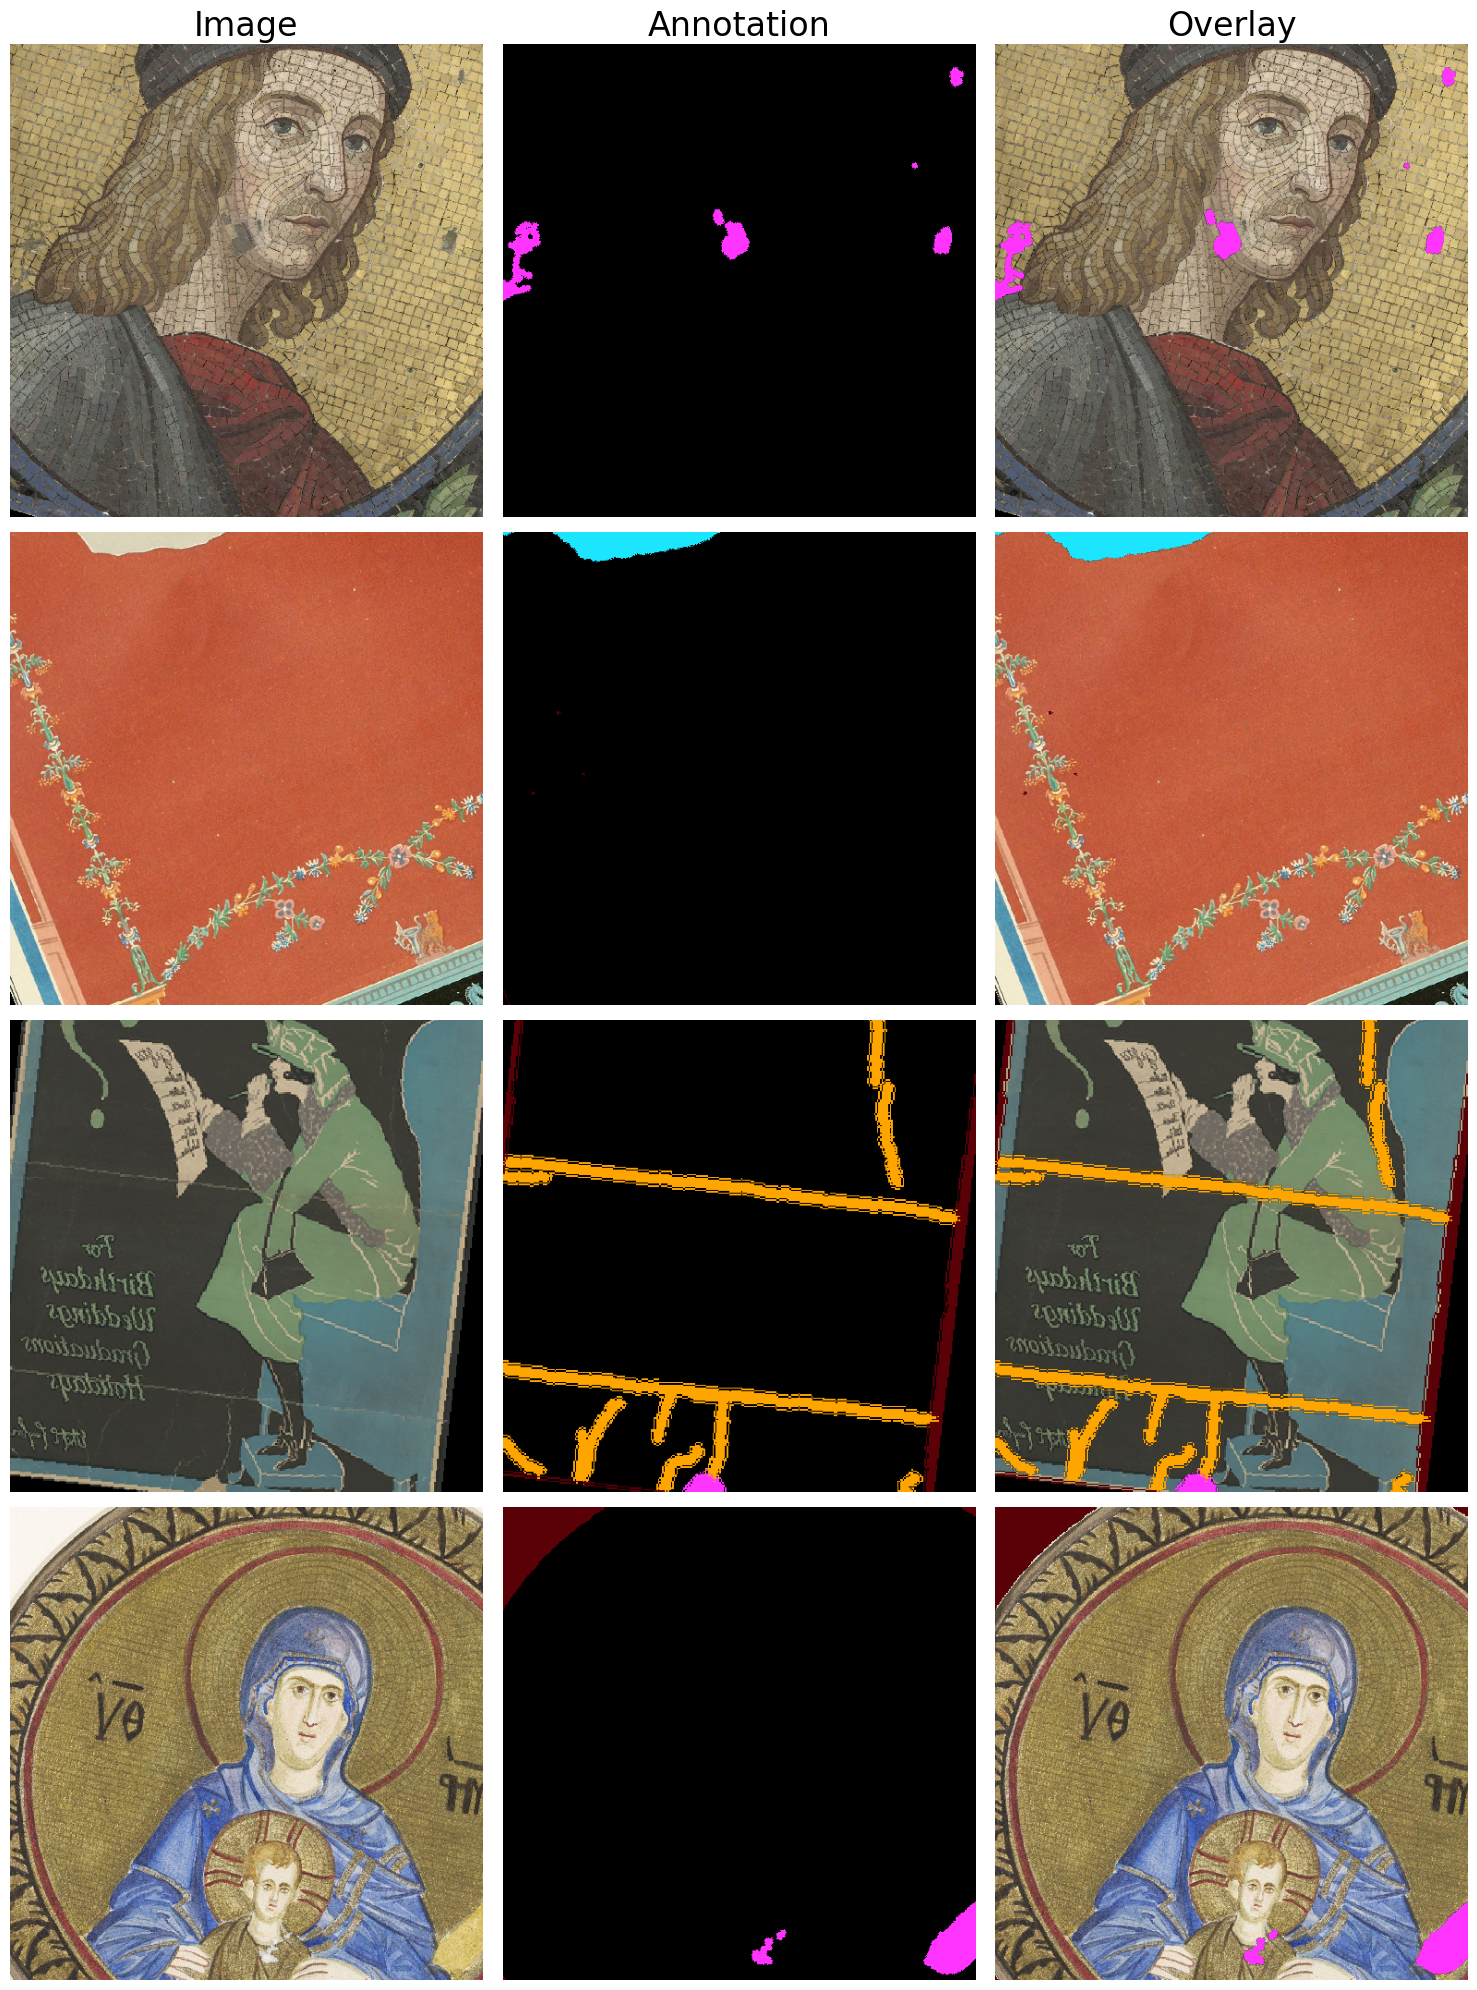

In [200]:
example_batch = next(iter(train_loader))

example_images = example_batch['image']
example_annotations = example_batch['annotation']
example_annotation_rgbs = example_batch['annotation_rgb']

# Number of examples to visualize
N = min(6, len(example_images))
print(len(example_images))

fig, axes = plt.subplots(N, 3, figsize=(15, 5 * N))

for ax, col in zip(axes[0], ['Image', 'Annotation', 'Overlay']):
    ax.set_title(col, fontsize=24)

for i in range(N):
    example_image = denormalize(example_images[i].numpy().transpose((1, 2, 0)), mean, std)  # C, H, W -> H, W, C
    example_annotation = Image.fromarray(np.uint8(example_annotations[i].numpy()), 'L')
    example_annotation_rgb = example_annotation_rgbs[i].numpy().transpose((1, 2, 0))  # C, H, W -> H, W, C

    # Create an alpha (transparency) channel where black pixels in annotation_rgb are fully transparent
    alpha_channel = np.all(example_annotation_rgb == [0, 0, 0], axis=-1)
    example_annotation_rgba = np.dstack((example_annotation_rgb, np.where(alpha_channel, 0, 1)))

    axes[i, 0].imshow(example_image)
    axes[i, 0].axis('off')

    axes[i, 1].imshow(example_annotation, cmap='gray', vmin=0, vmax=255)
    axes[i, 1].imshow(example_annotation_rgb)
    axes[i, 1].axis('off')

    axes[i, 2].imshow(example_image)
    axes[i, 2].imshow(example_annotation_rgba)
    axes[i, 2].axis('off')

plt.tight_layout()
plt.show()

Visualising the validation set, which loads the left-out class as whole images.

(985, 1024, 3)
(1024, 715, 3)
(1024, 743, 3)
(1024, 712, 3)


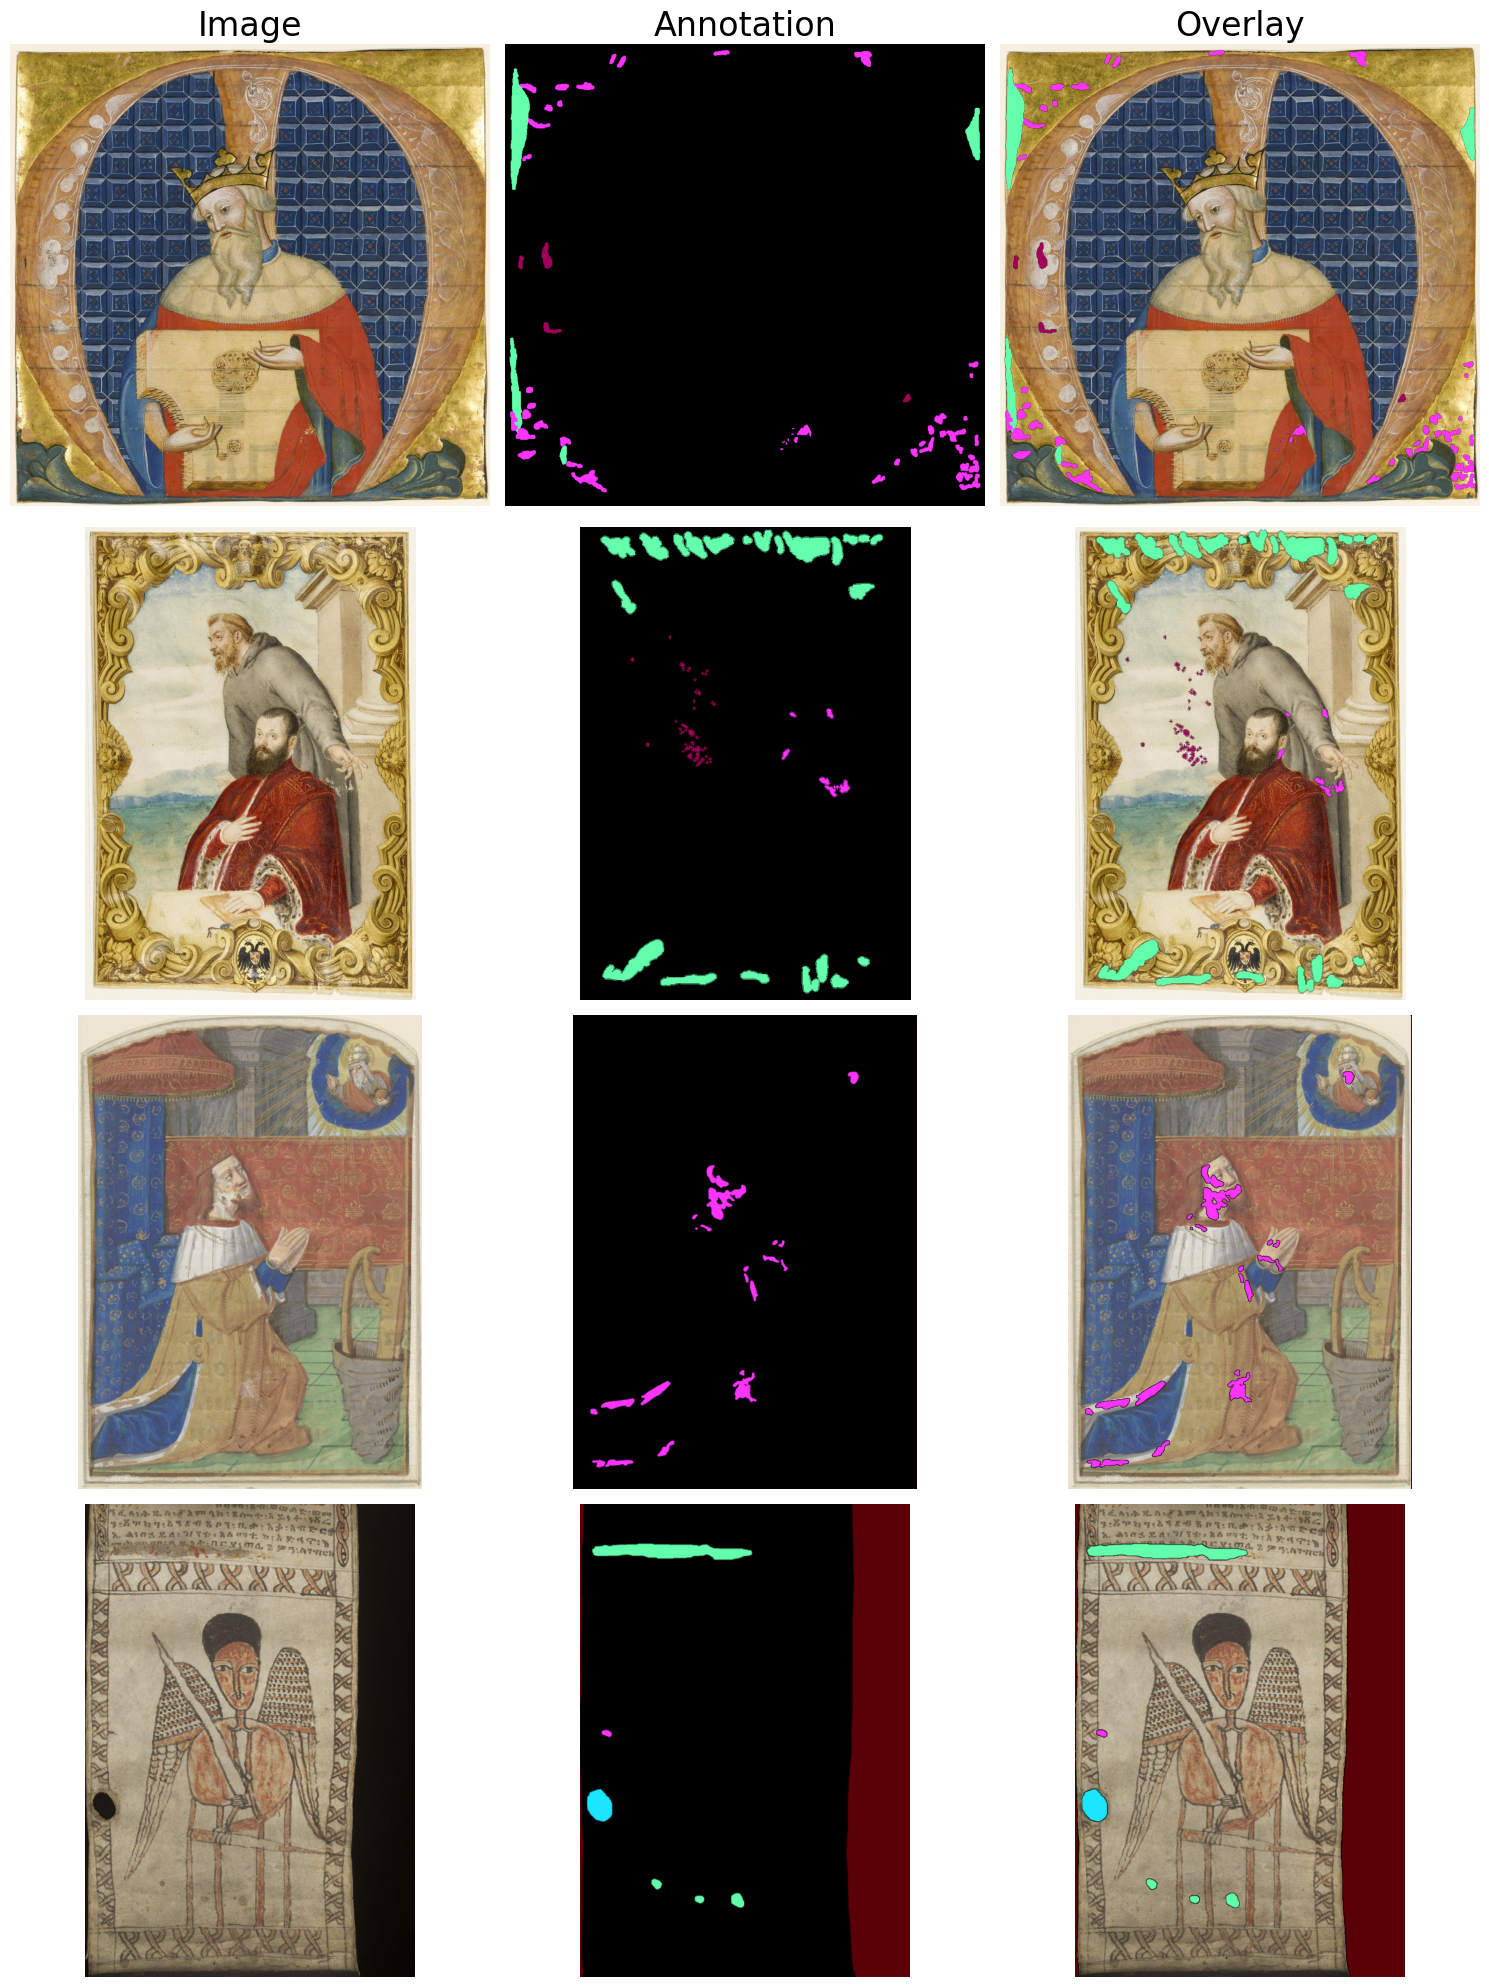

In [201]:
val_iter = iter(val_loader)
example_batches = [next(val_iter) for _ in range(4)]

# Initialize empty lists to collect different parts of each batch
example_images = []
example_annotations = []
example_annotation_rgbs = []
example_materials = []
example_contents = []

# Populate the lists with the data from the 4 batches
for batch in example_batches:
    example_images.append(batch['image'].squeeze())
    example_annotations.append(batch['annotation'].squeeze())
    example_annotation_rgbs.append(batch['annotation_rgb'].squeeze())
    example_materials.append(batch['material'][0])
    example_contents.append(batch['content'][0])

# Number of examples to visualize
N = min(4, len(example_images))

fig, axes = plt.subplots(N, 3, figsize=(15, 5 * N))

for ax, col in zip(axes[0], ['Image', 'Annotation', 'Overlay']):
    ax.set_title(col, fontsize=24)

for i in range(N):
    example_image = denormalize(example_images[i].numpy().transpose((1, 2, 0)), mean, std)  # C, H, W -> H, W, C
    print(example_image.shape)
    example_annotation = example_annotations[i].numpy()
    example_annotation_rgb = example_annotation_rgbs[i].numpy().transpose((1, 2, 0))  # C, H, W -> H, W, C
    example_material = example_materials[i]
    example_content = example_contents[i]
    # Create an alpha (transparency) channel where black pixels in annotation_rgb are fully transparent
    alpha_channel = np.all(example_annotation_rgb == [0, 0, 0], axis=-1)
    example_annotation_rgba = np.dstack((example_annotation_rgb, np.where(alpha_channel, 0, 1)))
    axes[i, 0].imshow(example_image)
    axes[i, 0].axis('off')

    axes[i, 1].imshow(example_annotation_rgb)
    axes[i, 1].axis('off')

    axes[i, 2].imshow(example_image)
    axes[i, 2].imshow(example_annotation_rgba)
    axes[i, 2].axis('off')

plt.tight_layout()
plt.show()

# 1) Understanding the dataset

## What is the data?
The dataset provided for this task consists of a diverse collection of images depicting various forms of damage, including but not limited to damage types such as scratches, tears, stains, and folds, found across different materials such as parchment, ceramics, and wood paintings. Each image in the dataset is accompanied by detailed annotations, providing information about the location and type of damage present in the image. These annotations serve as* ground truth labels* for training and evaluating the deep learning model.

##Pre-processing
Before training the model, preprocessing steps need to be applied to the dataset. This includes standardizing the size and format of the images, ensuring consistency in labeling and annotation formats, and performing data augmentation techniques such as random cropping, rotation, and flipping to increase the diversity and robustness of the training data. Luckily standardisation is already applied to the dataset. Additional processing such as rotation and flipping has been added to the `CustomDataset`.

## Further Processing
 Additionally, the dataset may need to be split into training, validation, and test sets to facilitate model training and evaluation while ensuring proper generalization to unseen data. By carefully preprocessing the dataset, we can enhance the model's ability to effectively learn and recognize different types of damage in images.

In [202]:
def visualize_result(inputs, outputs, targets, mean, std, num_classes):
    with torch.no_grad():
        # Denormalize and transpose the input image
        input_image = denormalize(inputs.numpy().transpose(1, 2, 0), mean, std)
        # Visualize original image
        plt.imshow(input_image)
        plt.title('Original Image')
        plt.axis('off')
        plt.show()

        # Visualize predicted segmentation
        output_image = denormalize(outputs.numpy().transpose(1, 2, 0), mean, std)
        plt.imshow(output_image, vmin=0, vmax=num_classes - 1)
        plt.title('Predicted Segmentation')
        plt.axis('off')
        plt.show()

        # Visualize ground truth segmentation
        target_image = denormalize(targets.numpy().transpose(1, 2, 0), mean, std)
        plt.imshow(target_image, vmin=0, vmax=num_classes - 1)
        plt.title('Real Segmentation')
        plt.axis('off')
        plt.show()

In [215]:
material = 'Parchment'
img_size = 64
content = 'Artistic depiction'
batch_size = 2

splits = {name: group for name,
          group in df.groupby("material")}

material_set = CustomDataset(dataframe=splits[material],
                             target_size=img_size,
                             is_train = True,
                             )

material_train_loader = DataLoader(material_set,
                             batch_size= batch_size,
                             shuffle=True,
                             num_workers = 0
                             )

material_set = CustomDataset(dataframe=splits[material],
                             target_size=img_size,
                             is_train = False,
                             )

material_val_loader = DataLoader(material_set,
                                 batch_size=1,
                                 shuffle=False,
                                 num_workers=0)

data_module = CustomDataModule(loocv_splits=full_splits,
                               current_material='Parchment',
                               target_size=img_size,
                               batch_size=batch_size,
                               filter_content = True,
                               content = content,)

# Define data loaders

data_module.setup()
train_loader = data_module.train_dataloader()
valid_loader = data_module.val_dataloader()

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


# 2) Picking a Model

## Supervised or Unsupervised?

I believe supervised learning is more suitable for the task of damage detection and identification in images due to the availability of annotated data, which provides explicit labels for the different types of damages present in the images. In supervised learning, the model learns to map input images to corresponding output labels by minimizing a predefined loss function, leveraging the ground truth annotations during training. This allows the model to capture complex patterns and relationships between image features and damage types, ultimately enabling it to make accurate predictions on unseen data. On the other hand, unsupervised learning, while powerful in discovering underlying structures in data without explicit labels, may not be directly applicable here as it relies on the absence of labeled data and may not effectively capture the nuances of damage types without explicit supervision. Therefore, supervised learning is a more suitable approach for this task, facilitating the creation of a robust damage detection and identification system.

## Picking architecture

For a image classification task, an appropriate segmentation model should be picked. The models considered were:

**Simple SegmentationModel:** The SegmentationModel architecture integrates convolutional layers, max-pooling operations, and upsampling layers to capture local and global features efficiently. With ReLU activation functions, it promotes rapid convergence during training, enabling effective learning of complex patterns. Its simplicity and flexibility make it suitable for diverse segmentation tasks across domains, offering a balanced mix of computational efficiency and performance.

**U-Net:** U-Net is a popular architecture for semantic segmentation, especially when dealing with medical image segmentation tasks. It consists of a contracting path (encoder) followed by an expansive path (decoder), which helps to capture both local and global context information effectively.

**SegNet:** SegNet is an encoder-decoder architecture designed for semantic segmentation. It consists of convolutional and pooling layers in the encoder followed by upsampling and convolutional layers in the decoder to generate the segmentation map.



In [209]:
class SegmentationModel(pl.LightningModule):
    def __init__(self, in_channels, out_channels, lr=1e-3, optimise = torch.optim.Adam, loss_func = F.cross_entropy, in_bin=False):
        super(SegmentationModel, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, out_channels, kernel_size=3, padding=1)
        # Add a max pooling layer to reduce spatial dimensions
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # Add upsampling layers
        self.upsample1 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        #lr, optimisation, and loss function
        self.lr = lr
        self.optimise = optimise
        self.loss_func = loss_func

        #To switch from mask to rgb images
        self.in_bin = in_bin

    #For switching model parameters
    def setParams(self, in_channels=None, out_channels=None, optimise=None, loss_func=None):
        if in_channels is not None:
            self.in_channels = in_channels
        if out_channels is not None:
           self.out_channels = out_channels
        if optimise is not None:
            self.optimise = optimise
        if loss_func is not None:
            self.loss_func = loss_func

    def switchToBinary(self):
        self.setParams(out_channels=1)
        self.in_bin = True

    def switchToRGB(self):
        self.setParams(out_channels=3)
        self.in_bin = False

    def forward(self, x):
        x = self.upsample1(x)
        x = F.relu(self.conv1(x))
        x = self.max_pool(x)
        x = F.relu(self.conv2(x))
        x = self.conv3(x)
        return x

    def training_step(self, batch, batch_idx):
        if self.in_bin:
            x, y = batch['image'], batch['annotation']
        else:
            x, y = batch['image'], batch['annotation_rgb']
        y_hat = self(x)
        loss = self.loss_func(y_hat, y)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        if self.in_bin:
            x, y = batch['image'], batch['annotation']
        else:
            x, y = batch['image'], batch['annotation_rgb']
        y_hat = self(x)
        loss = self.loss_func(y_hat, y)
        self.log('val_loss', loss)

    def test_step(self, batch, batch_idx):
        if self.in_bin:
            inputs, targets = batch['image'], batch['annotation']
        else:
            inputs, targets = batch['image'], batch['annotation_rgb']
        outputs = self(inputs)

        # Compute loss
        loss = self.loss_func(outputs, targets)

        # Visualize the results
        visualize_result(inputs[0], outputs[0], targets[0], mean, std, num_classes)

    def configure_optimizers(self):
        return self.optimise(self.parameters(), lr=self.lr)



In [210]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Down, self).__init__()
        self.max_pool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.max_pool_conv(x)


class Up(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Up, self).__init__()
        self.up = nn.ConvTranspose2d(in_channels // 2, in_channels // 2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)

        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2])
        # Concatenate along the channels axis
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class UNet(pl.LightningModule):
    def __init__(self, in_channels, out_channels, features=[64, 128, 256, 512], lr=1e-3, optimise=torch.optim.Adam, loss_func = F.cross_entropy, in_bin=False):
        super(UNet, self).__init__()
        self.downs = nn.ModuleList([Down(in_channels, features[0])])
        self.downs.extend([Down(features[i], features[i + 1]) for i in range(len(features) - 1)])
        self.ups = nn.ModuleList([Up(features[i], features[i - 1]) for i in range(len(features) - 1, 0, -1)])
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

        #lr, optimisation, and loss function
        self.lr = lr
        self.optimise = optimise
        self.loss_func = loss_func

        #To switch from mask to rgb images
        self.in_bin = in_bin

    #For switching model parameters
    def setParams(self, in_channels=None, out_channels=None, optimise=None, loss_func=None):
        if in_channels is not None:
            self.in_channels = in_channels
        if out_channels is not None:
           self.out_channels = out_channels
        if optimise is not None:
            self.optimise = optimise
        if loss_func is not None:
            self.loss_func = loss_func

    def switchToBinary(self):
        self.setParams(out_channels=1)
        self.in_bin = True

    def switchToRGB(self):
        self.setParams(out_channels=3)
        self.in_bin = False

    def forward(self, x):
        skip_connections = []
        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
        skip_connections = skip_connections[::-1][1:]
        for up, skip in zip(self.ups, skip_connections):
            x = up(x, skip)
        return self.final_conv(x)

    def training_step(self, batch, batch_idx):
        if self.in_bin:
            x, y = batch['image'], batch['annotation']
        else:
            x, y = batch['image'], batch['annotation_rgb']
        y_hat = self(x)
        loss = self.loss_func(y_hat, y)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        if self.in_bin:
            x, y = batch['image'], batch['annotation']
        else:
            x, y = batch['image'], batch['annotation_rgb']
        y_hat = self(x)
        loss = self.loss_func(y_hat, y)
        self.log('val_loss', loss)

    def test_step(self, batch, batch_idx):
        if self.in_bin:
            inputs, targets = batch['image'], batch['annotation']
        else:
            inputs, targets = batch['image'], batch['annotation_rgb']
        outputs = self(inputs)

        # Compute loss
        loss = self.loss_func(outputs, targets)

        # Visualize the results
        visualize_result(inputs[0], outputs[0], targets[0], mean, std, num_classes)

    def configure_optimizers(self):
        return self.optimise(self.parameters(), lr=self.lr)


In [211]:
class SegNet(pl.LightningModule):
    def __init__(self, in_channels, out_channels, lr=1e-3, optimise=torch.optim.Adam, loss_func=F.cross_entropy, in_bin=False):
        super(SegNet, self).__init__()

        # Encoder layers
        self.encoder_conv1 = nn.Conv2d(in_channels, 32, kernel_size=3, padding=1)
        self.encoder_conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.encoder_conv3 = nn.Conv2d(64, 64, kernel_size=3, padding=1)

        # Max pooling layers with indices for pooling
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)

        # Decoder layers with upsampling using pooling indices
        self.decoder_conv1 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.decoder_conv2 = nn.Conv2d(64, 32, kernel_size=3, padding=1)
        self.decoder_conv3 = nn.Conv2d(32, out_channels, kernel_size=3, padding=1)

        self.unpool = nn.MaxUnpool2d(kernel_size=2, stride=2)

        # lr, optimisation, and loss function
        self.lr = lr
        self.optimise = optimise
        self.loss_func = loss_func

        # To switch from mask to rgb images
        self.in_bin = in_bin

    #For switching model parameters
    def setParams(self, in_channels=None, out_channels=None, optimise=None, loss_func=None):
        if in_channels is not None:
            self.in_channels = in_channels
        if out_channels is not None:
           self.out_channels = out_channels
        if optimise is not None:
            self.optimise = optimise
        if loss_func is not None:
            self.loss_func = loss_func

    def switchToBinary(self):
        self.setParams(out_channels=1)
        self.in_bin = True

    def switchToRGB(self):
        self.setParams(out_channels=3)
        self.in_bin = False

    def forward(self, x):
        # Encoder
        x, indices1 = self.max_pool(F.relu(self.encoder_conv1(x)))
        x, indices2 = self.max_pool(F.relu(self.encoder_conv2(x)))
        x, indices3 = self.max_pool(F.relu(self.encoder_conv3(x)))

        # Decoder with upsampling using pooling indices
        x = F.relu(self.decoder_conv1(self.unpool(x, indices3)))
        x = F.relu(self.decoder_conv2(self.unpool(x, indices2)))
        x = self.decoder_conv3(self.unpool(x, indices1))  # No activation for output

        return x

    def training_step(self, batch, batch_idx):
        if self.in_bin:
            x, y = batch['image'], batch['annotation']
        else:
            x, y = batch['image'], batch['annotation_rgb']
        y_hat = self(x)
        loss = self.loss_func(y_hat, y)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        if self.in_bin:
            x, y = batch['image'], batch['annotation']
        else:
            x, y = batch['image'], batch['annotation_rgb']
        y_hat = self(x)
        loss = self.loss_func(y_hat, y)
        self.log('val_loss', loss)

    def test_step(self, batch, batch_idx):
        if self.in_bin:
            inputs, targets = batch['image'], batch['annotation']
        else:
            inputs, targets = batch['image'], batch['annotation_rgb']
        outputs = self(inputs)

        # Compute loss
        loss = self.loss_func(outputs, targets)

        # Visualize the results
        visualize_result(inputs[0], outputs[0], targets[0], mean, std, num_classes)

    def configure_optimizers(self):
        return self.optimise(self.parameters(), lr=self.lr)



## The Pick: SegmentationModel
### Advantages of Using SegmentationModel

The SegmentationModel offers several advantages that make it an ideal choice for semantic segmentation tasks compared to other standard models like U-Net or SegNet:

1. **Simplicity and Flexibility:** SegmentationModel has a simpler architecture compared to U-Net and SegNet, making it easier to understand and modify. It consists of basic convolutional layers followed by upsampling layers, which allows for flexibility in adapting the model to different datasets and tasks.

2. **Efficiency:** The model's architecture, with its straightforward convolutional and upsampling layers, leads to efficient training and inference. It strikes a balance between model complexity and computational cost, making it suitable for training on datasets of various sizes without excessive resource requirements.

3. **Customizable Input and Output Channels:** SegmentationModel allows for easy customization of input and output channels through its `in_channels` and `out_channels` parameters. This flexibility enables the model to handle different input modalities and output classes, accommodating diverse segmentation tasks without significant architectural modifications.

4. **Adaptability to Binary and RGB Outputs:** The model's ability to switch between binary and RGB output channels using the `switchToBinary()` and `switchToRGB()` methods adds versatility. This feature is particularly useful when dealing with different annotation formats or when transitioning between binary and multi-class segmentation tasks within the same pipeline.

5. **PyTorch Lightning Integration:** SegmentationModel is seamlessly integrated with PyTorch Lightning, a lightweight PyTorch wrapper for streamlining the training process. This integration simplifies model training, validation, and testing, enhancing productivity and code maintainability.

While other standardized models like U-Net and SegNet are also suitable for semantic segmentation, they often require more research and experimentation to adapt to specific datasets and tasks. Their more rigid architectures may necessitate additional efforts in tuning hyperparameters and handling complex optimization challenges.



# Training the Model

The optimiser and loss function needs to be picked before training can take place.

**Loss Function** ***(CrossEntropyLoss)***: The CrossEntropyLoss is commonly used for multi-class classification tasks like semantic segmentation, where each pixel is classified into one of several classes. It computes the cross-entropy loss between the predicted class probabilities and the ground truth labels. Alternative loss functions such as Dice Loss or IoU Loss could be considered, especially for imbalanced datasets or when optimizing for intersection over union metrics. However, CrossEntropyLoss is a suitable choice for this task and is widely used in semantic segmentation.

**Optimizer** ***(Adam)***: The Adam optimizer is chosen due to its adaptive learning rate method, which adjusts the learning rates of each parameter individually based on past gradients and squared gradients. This adaptive behavior helps to converge faster and is less sensitive to the choice of hyperparameters like the learning rate. Alternative optimizers like SGD (Stochastic Gradient Descent) with momentum could be considered, but Adam generally performs well in practice and is a popular choice for deep learning tasks.

Training parameters i.e. hyperparameters are picked before training, these will define the behaviour of the loss function and optimiser:

**Learning Rate** ***(lr=0.01)***: The learning rate determines the step size at each iteration during optimization. A value of 0.01 is chosen, which is a common starting point and often yields good to mediocre results. However, the learning rate can significantly impact training performance, and it may need to be adjusted during training using learning rate schedulers or manually based on validation performance.

**Batch Size**: The batch size defines the number of samples processed before updating the model parameters. A batch size of unspecified size is used in the code segment, which could be adjusted based on available memory and computational resources. Larger batch sizes generally lead to faster convergence but may require more memory.

**Number of Epochs** ***(num_epochs=5)***: The number of epochs determines the number of times the entire dataset is passed through the model during training. Five epochs are chosen as a starting point, due to the time consuming nature of the model, but this value can be adjusted based on convergence behavior observed during training. Ideally a higher number of epochs is used for the final training. Training for too few epochs may result in underfitting, while training for too many epochs may lead to overfitting.

In [212]:
#TRAIN FLAG, SET TO FALSE FOR JUST ANALYSIS
TRAIN_FLAG = True

#BIN FLAG, SET TO FALSE IF ONLY RGB SHOULD BE TRAINED
BIN_FLAG = False

In [216]:
#Restrict dataset
if True:
    train_loader = material_train_loader
    val_loader = material_val_loader

In [220]:
# Define the directory to save the model
root_dir = "/content/drive/MyDrive/DL"
save_dir = os.path.join(root_dir, '/saved_models')
os.makedirs(save_dir, exist_ok=True)

#Set Hyperparameters:
lr = 0.01
optimise = torch.optim.Adam
loss_func = F.cross_entropy
epochs = 5

# Initialize the model
model = SegmentationModel(3,3, lr, optimise, loss_func)

## Binary & MultiClass Approach
I believe that by gradually increasing the complexity of the data provided to train and validate the model, we can more efficiently and effectively train the model. Some of the benefits of training the model with increasing complexity are:

**Efficient Training**: By training the model for binary segmentation first and then switching to multi-class segmentation, we can efficiently utilize computational resources. Binary segmentation typically requires less computational resources compared to multi-class segmentation. By training the model in stages, we can focus on each task separately, potentially reducing training time and resource consumption.

**Gradual Complexity Increase:** Starting with binary segmentation allows the model to learn fundamental segmentation tasks, such as separating damaged pixels from undamaged ones. Once the model has learned these basic tasks, switching to multi-class segmentation introduces additional complexity by distinguishing between different types of damages. This gradual increase in complexity can lead to better convergence and performance.

**Better Initialization:** Training the model for binary segmentation first provides a better initialization for subsequent training for multi-class segmentation. The parameters learned during binary segmentation can serve as a good starting point for training the more complex multi-class segmentation task. This initialization may help the model converge faster and achieve better performance in the multi-class setting.

**Easier Interpretation and Debugging:** Separating the training into distinct stages makes it easier to interpret and debug the model's performance. By evaluating the model's performance at each stage separately, we can better understand its strengths and weaknesses. This approach allows for more targeted adjustments and improvements, leading to better overall performance.

**Flexibility in Model Architecture and Loss Function:** Training the model in stages allows for flexibility in model architecture and loss function selection. We can choose different architectures and loss functions tailored to each stage of training. For example, using binary cross-entropy loss for binary segmentation and categorical cross-entropy loss for multi-class segmentation. This flexibility enables us to optimize the model for each specific task, potentially leading to better performance.

In [221]:
# Initialize LearningRateMonitor
lr_monitor = LearningRateMonitor(logging_interval='epoch')

# Initialize ModelCheckpoint
checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',
    dirpath= os.path.join(root_dir, '/checkpoints/'),
    filename='seg_model_{epoch:02d}-{val_loss:.2f}',
    save_top_k=3,
    mode='min'
)

# Initialize the model for binary segmentation if BIN_FLAG is True
if BIN_FLAG:
    num_classes_binary = 2
    model.switchToBinary()
    model.setParams(in_channels=1, out_channel = num_classes_binary, loss_func=F.binary_cross_entropy)

    # Training for binary segmentation
    if TRAIN_FLAG:
        # Initialize CSVLogger
        logger = CSVLogger(os.path.join(root_dir, '/logs'), name="seg_model_binary")

        # Initialize a Trainer
        trainer = pl.Trainer(
            max_epochs=epochs,
            logger=logger,
            accelerator="auto",
            devices="auto",
            enable_checkpointing=True,
            max_time={"hours": 1}
        )

        # Start training
        trainer.fit(model, train_loader, valid_loader)

        # Save the model checkpoint after binary segmentation
        checkpoint_path_binary = os.path.join(save_dir, 'seg_model_binary.pth')
        torch.save(model.state_dict(), checkpoint_path_binary)

    # Adjust the model for multi-class segmentation
    model.switchToRGB()
    model.setParams(in_channels=3, out_channels=3, optimise=optimise, loss_func = loss_func)

    # Continue training for multi-class segmentation
    if TRAIN_FLAG:
        # Initialize CSVLogger
        logger = CSVLogger(os.path.join(root_dir, '/logs'), name='seg_model_multiclass')

        # Initialize a new Trainer
        trainer = pl.Trainer(
            max_epochs=epochs,
            logger=logger,
            accelerator="auto",
            devices="auto",
            enable_checkpointing=True,
            max_time={"hours": 1}
        )

        # Start training
        trainer.fit(model, train_loader, valid_loader)

        # Save the final model checkpoint after multi-class segmentation
        checkpoint_path_multi = os.path.join(save_dir, 'seg_model_multiclass.pth')
        torch.save(model.state_dict(), checkpoint_path_multi)

# After binary segmentation, switch to multi-class segmentation if BIN_FLAG is False or TRAIN_FLAG is True
if not BIN_FLAG:
    # Adjust the model for multi-class segmentation
    model.switchToRGB()
    model.setParams(in_channels=3, out_channels=3, optimise=optimise, loss_func = loss_func)

    # Load the model checkpoint from binary segmentation if TRAIN_FLAG is False
    if not TRAIN_FLAG:
        checkpoint_path_binary = checkpoint_callback.best_model_path
        model.load_state_dict(torch.load(checkpoint_path_binary))

    # Continue training for multi-class segmentation
    if TRAIN_FLAG:
        # Initialize CSVLogger
        logger = CSVLogger(os.path.join(root_dir, '/logs'), name='seg_model_multiclass')

        # Initialize a new Trainer
        trainer = pl.Trainer(
            max_epochs=epochs,
            logger=logger,
            accelerator="auto",
            devices="auto",
            enable_checkpointing=True,
            max_time={"hours": 1}
        )

        # Start training
        trainer.fit(model, train_loader, valid_loader)

        # Save the final model checkpoint after multi-class segmentation
        checkpoint_path_multi = os.path.join(save_dir, 'seg_model_multiclass.pth')
        torch.save(model.state_dict(), checkpoint_path_multi)


INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type      | Params
----------------------------------------
0 | conv1     | Conv2d    | 1.8 K 
1 | conv2     | Conv2d    | 36.9 K
2 | conv3     | Conv2d    | 1.7 K 
3 | max_pool  | MaxPool2d | 0     
4 | upsample1 | Upsample  | 0     
----------------------------------------
40.5 K    Trainable params
0         Non-trainable params
40.5 K    Total params
0.162     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (11) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=2` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


# Evaluation

For the final evaluation of the model, make sure to test performance on the left out category, `Canvas` to have a fair idea on how well the model generalises.

In [238]:
test_module = CustomDataModule(loocv_splits=full_splits,
                               current_material='Canvas',
                               target_size=512,
                               batch_size=4)

test_module.setup()

test_loader = test_module.val_dataloader()

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [239]:
#load model from drive
model.load_state_dict(torch.load(os.path.join(save_dir, 'seg_model_multiclass.pth')))
trainer.test(model, dataloaders=DataLoader(test_set))

Testing: |          | 0/? [00:00<?, ?it/s]

KeyError: 0

In [ ]:
"""
import matplotlib.pyplot as plt
import torch

def visualize_annotations(model, test_loader, num_samples, mean = mean, std = std, num_classes= num_classes):
    model.eval()
    with torch.no_grad():
        for batch_idx, batch in enumerate(test_loader):
            if batch_idx >= num_samples:
                break

            inputs, targets = batch['image'], batch['annotation_rgb']

            # Forward pass
            outputs = model(inputs)

            # Visualize
            fig, axes = plt.subplots(inputs.shape[0], 3, figsize=(15, 5 * inputs.shape[0]))
            print("inputs.shape: ", inputs.shape)
            for i in range(inputs.shape[0]):
                # Denormalize and transpose the input image
                input_image = denormalize(inputs[i].numpy().transpose(1, 2, 0), mean, std)
                # Visualize original image
                axes[i].imshow(input_image)
                axes[i].set_title('Original Image')
                axes[i].axis('off')

                # Visualize predicted segmentation
                output_image = denormalize(outputs[i].numpy().transpose(1, 2, 0), mean, std)

                axes[i+1].imshow(output_image, vmin=0, vmax=num_classes - 1)
                axes[i+ 1].set_title('Predicted Segmentation')
                axes[i+ 1].axis('off')

                # Visualize ground truth segmentation
                print("targets.shape: ", targets[i].shape)
                target_image = denormalize(targets[i].numpy().transpose(1, 2, 0), mean, std)
                axes[i+ 2].imshow(target_image, vmin=0, vmax=num_classes - 1)
                axes[i+ 2].set_title('Real Segmentation')
                axes[i+ 2].axis('off')

            plt.tight_layout()
            plt.show()


visualize_annotations(model, test_loader, 10)
"""